In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox

In [ ]:
# Load the data
drug_data = pd.read_csv('drug.txt', sep=',', skiprows=1)
drug_data.columns = ['Date', 'Value']

# Convert 'Date' column to datetime  to ensure that the dates are treated correctly for plotting, indexing, and analysis purposes.
drug_data['Date'] = pd.to_datetime(drug_data['Date'])

# Set 'Date' column as the index to work with time series data effectively.
drug_data.set_index('Date', inplace=True)

In [ ]:
drug_data.head()

,Value
Date,
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
1991-12-01,4.306371


In [ ]:
def adf_kpss_test(diff_data,res=0):
  # ADF test
  if res == 0:
    result_adf = adfuller(diff_data['Value'])
  else:
    result_adf = adfuller(diff_data)
  print('ADF Statistic:', result_adf[0])
  print('p-value:', result_adf[1])
  print('Critical Values:')
  for key, value in result_adf[4].items():
      print('\t', key, ':', value)

  # KPSS test
  if res == 0:
    result_kpss = kpss(diff_data['Value'])
  else:
    result_kpss = kpss(diff_data)
  print('\nKPSS Statistic:', result_kpss[0])
  print('p-value:', result_kpss[1])
  print('Critical Values:')
  for key, value in result_kpss[3].items():
      print('\t', key, ':', value)

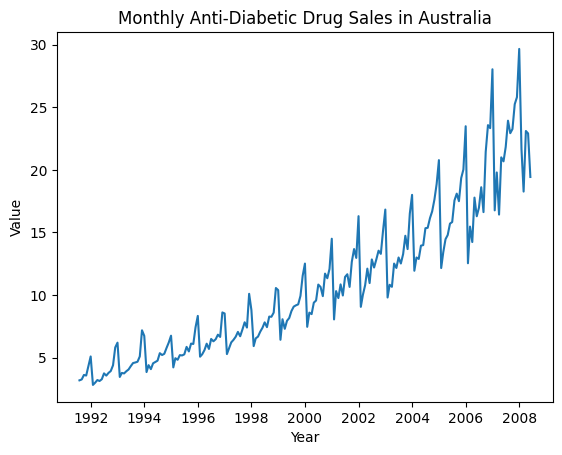

In [ ]:
# Plot the time series
plt.plot(drug_data)
plt.title('Monthly Anti-Diabetic Drug Sales in Australia')
plt.xlabel('Year')
plt.ylabel('Value')
plt.show()

Plot the ACF to identify the autocorrelation between the series and its lag values. The ACF helps determine the order of the ARIMA model's moving average (MA) component. Significant autocorrelation at lag k indicates a potential MA(k) term in the model.

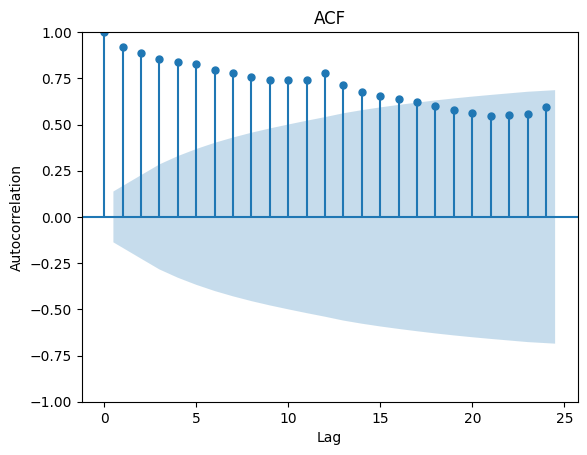

In [ ]:
#Autocorrelation Function (ACF)
plot_acf(drug_data)
plt.title('ACF')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

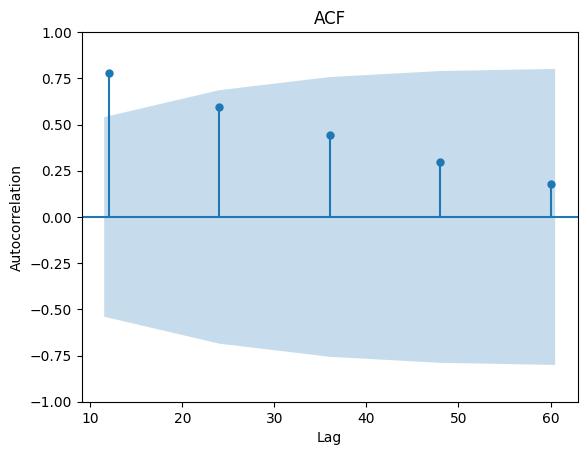

In [ ]:
#Autocorrelation Function (ACF)
plot_acf(drug_data,lags=[12,24,36,48,60])
plt.title('ACF')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

The above plots indicate that autocorrelation decreases gradually without clear spikes. This indicates a lower q value.

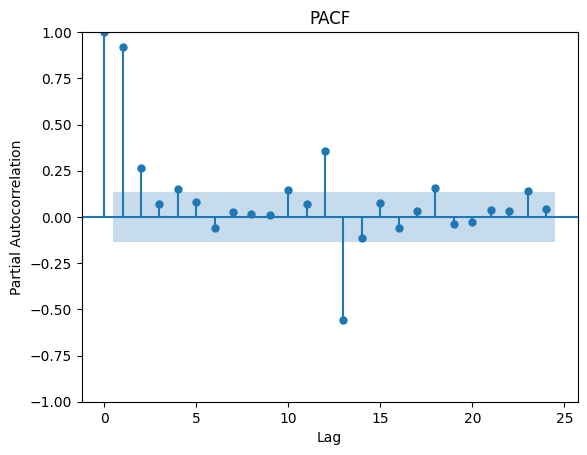

In [ ]:
#Partial Autocorrelation Function (PACF)
plot_pacf(drug_data)
plt.title('PACF')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

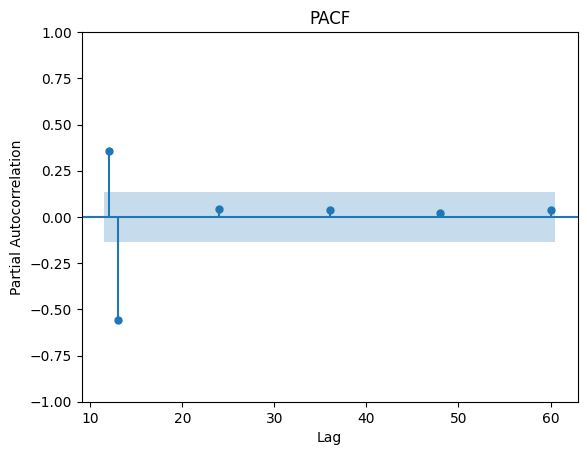

In [ ]:
# Partial Autocorrelation Function (PACF)
plot_pacf(drug_data,lags=[12,13,24,36,48,60])
plt.title('PACF')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

In light of both of the above plots, set p=13

After two lags, the ACF plot shows a slow decay, while the PACF plot shows a rapid decay. There is often a pattern of non-stationarity observed in time series data with trends or long-term dependencies.

In [ ]:
adf_kpss_test(drug_data)

ADF Statistic: 3.1544537427308663
p-value: 1.0
Critical Values:
	 1% : -3.465811691080702
	 5% : -2.877123351472649
	 10% : -2.5750770662586864

KPSS Statistic: 2.0043311481996122
p-value: 0.01
Critical Values:
	 10% : 0.347
	 5% : 0.463
	 2.5% : 0.574
	 1% : 0.739


<ipython-input-96-753d22cd55ea>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_kpss = kpss(diff_data['Value'])


The null hypothesis of the ADF test is that the data has a unit root, implying that it is non-stationary. A p-value of 1.0 indicates that we cannot reject the null hypothesis at any reasonable level of significance. Due to this, we are unable to reject the null hypothesis, suggesting that the data are not stationary.

The null hypothesis of the KPSS test is that the data are trend-stationary. As a result, the p-value of 0.01 is less than the significance level of 0.05. Therefore, we reject the null hypothesis in favor of the alternative hypothesis, which suggests that the data are not stationary.

Therefore, let's use logarithmic transformations

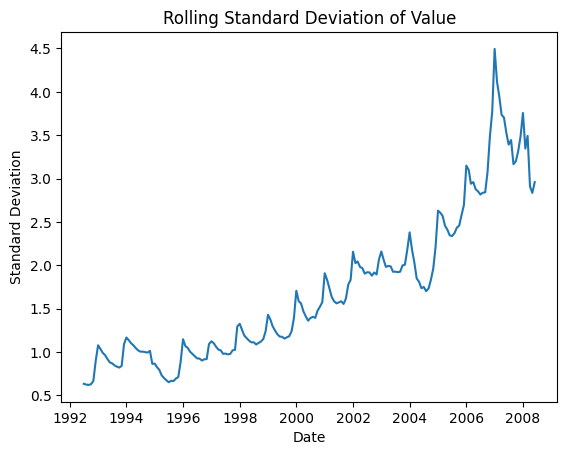

In [ ]:
# Check for non-constant variance
rolling_std = drug_data['Value'].rolling(window=12).std()
plt.plot(rolling_std)
plt.title('Rolling Standard Deviation of Value')
plt.xlabel('Date')
plt.ylabel('Standard Deviation')
plt.show()

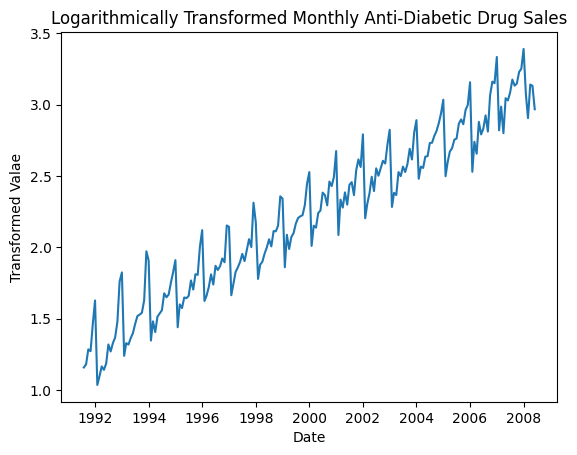

In [ ]:
# Apply logarithmic transformation
log_values = np.log(drug_data)

# Plot the series
plt.plot(log_values)
plt.title('Logarithmically Transformed Monthly Anti-Diabetic Drug Sales')
plt.xlabel('Date')
plt.ylabel('Transformed Valae')
plt.show()

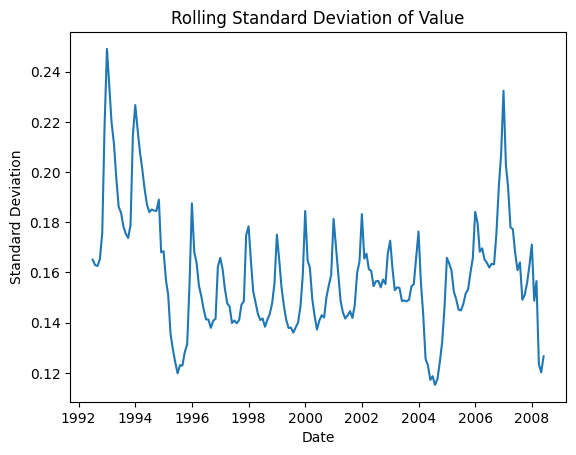

In [ ]:
# Check for non-constant variance
deviation_rolling = log_values.rolling(window=12).std()
plt.plot(deviation_rolling)
plt.title('Rolling Standard Deviation of Value')
plt.xlabel('Date')
plt.ylabel('Standard Deviation')
plt.show()

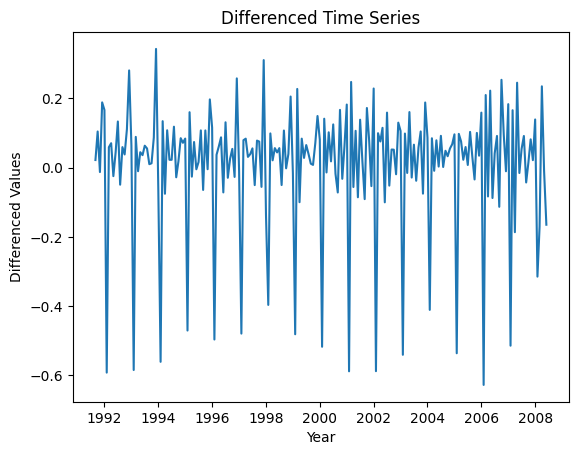

In [ ]:
#Differencing
diff_data = log_values.diff().dropna()

# Plot differenced series
plt.plot(diff_data)
plt.title('Differenced Time Series')
plt.xlabel('Year')
plt.ylabel('Differenced Values')
plt.show()

In [ ]:
adf_kpss_test(diff_data)

ADF Statistic: -3.88563812669621
p-value: 0.0021431220809530237
Critical Values:
	 1% : -3.466005071659723
	 5% : -2.8772078537639385
	 10% : -2.5751221620996647

KPSS Statistic: 0.19761211924828057
p-value: 0.1
Critical Values:
	 10% : 0.347
	 5% : 0.463
	 2.5% : 0.574
	 1% : 0.739


<ipython-input-96-753d22cd55ea>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss = kpss(diff_data['Value'])


There is strong evidence against the null hypothesis, as the p-value of 0.002 is less than the significance level of 0.05. As a result, we reject the null hypothesis, suggesting that the data are stationary. At all levels of significance, the ADF statistic falls below the critical value.

A p-value of 0.1 is greater than a significance level of 0.05. Accordingly, we do not reject the null hypothesis, indicating that the data are stationary. KPSS is below the critical value at all levels of significance.

In [ ]:
# Fit ARIMA model
model = ARIMA(diff_data, order=(2, 1, 1))
fit_model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


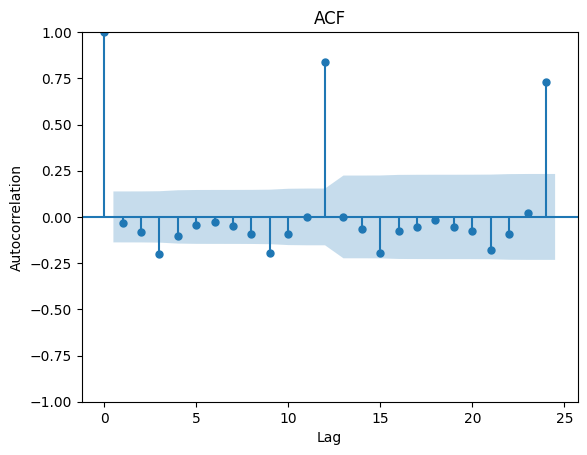

In [ ]:
# Refinement of the Model
residuals = fit_model.resid
plot_acf(residuals)
plt.title('ACF')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

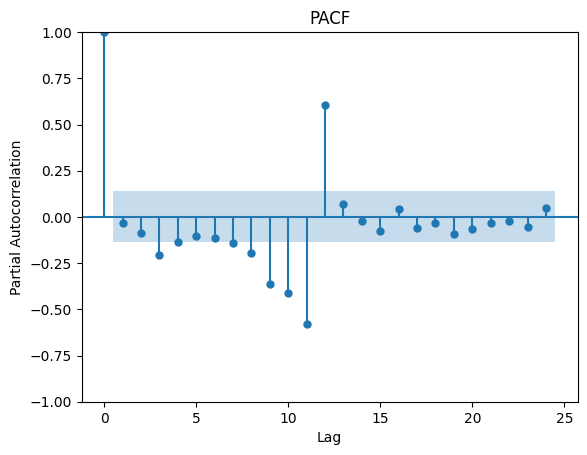

In [ ]:
plot_pacf(residuals)
plt.title('PACF')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [ ]:
order=(2,1,1)
print(f"ARIMA{order} - AIC: {fit_model.aic}")

ARIMA(2, 1, 1) - AIC: -127.5217555628268


In [ ]:
st = acorr_ljungbox(residuals, lags=[25],return_df=True)
print('\nLjung-Box Test Statistic:', st.lb_stat)
print('p-value:', st.lb_pvalue)


Ljung-Box Test Statistic: 25    322.642336
Name: lb_stat, dtype: float64
p-value: 25    1.671986e-53
Name: lb_pvalue, dtype: float64


In [ ]:
adf_kpss_test(residuals,1)

ADF Statistic: -3.8191495233568427
p-value: 0.0027173560217997983
Critical Values:
	 1% : -3.466005071659723
	 5% : -2.8772078537639385
	 10% : -2.5751221620996647

KPSS Statistic: 0.039976012636076905
p-value: 0.1
Critical Values:
	 10% : 0.347
	 5% : 0.463
	 2.5% : 0.574
	 1% : 0.739


<ipython-input-96-753d22cd55ea>:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss = kpss(diff_data)


In [ ]:
model_results = {
    'ARIMA(2, 1, 1)': {
        'AIC': -127.5217555628268,
        'Ljung-Box Test Statistic': 322.642336,
        'Ljung-Box p-value': 1.671986e-53,
        'ADF Statistic': -3.8191495233568427,
        'ADF p-value': 0.0027173560217997983,
        'KPSS Statistic': 0.039976012636076905,
        'KPSS p-value': 0.1
    }
}

As we see from the above, it is not a stationary plot. Hence, we continue refining the model by increasing p.

In [ ]:
# Fit ARIMA model
model = ARIMA(diff_data, order=(5, 1, 1))
fit_model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


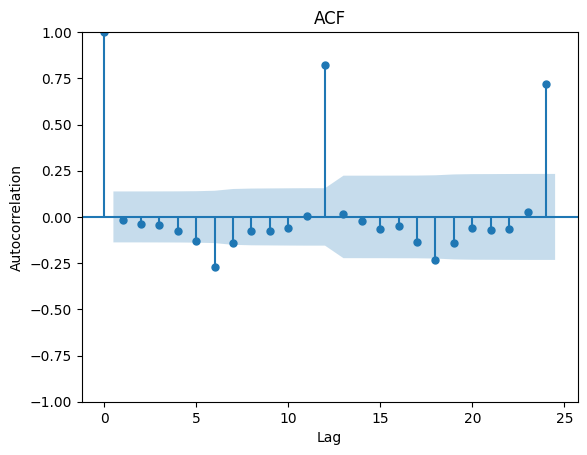

In [ ]:
# Refinement of the Model
residuals = fit_model.resid
plot_acf(residuals)
plt.title('ACF')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

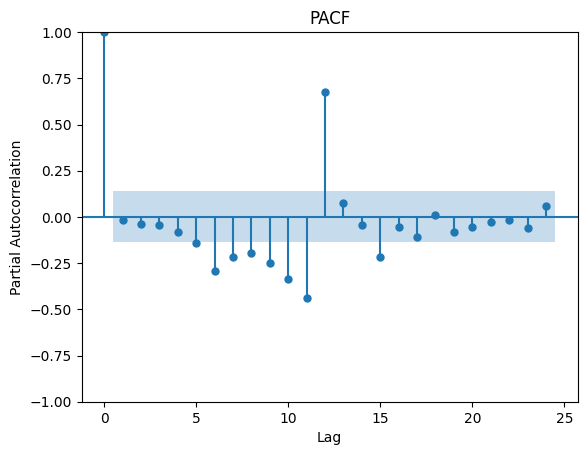

In [ ]:
plot_pacf(residuals)
plt.title('PACF')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [ ]:
order=(5,1,1)
print(f"ARIMA{order} - AIC: {fit_model.aic}")

ARIMA(5, 1, 1) - AIC: -136.03623247283917


In [ ]:
st = acorr_ljungbox(residuals, lags=[25],return_df=True)
print('\nLjung-Box Test Statistic:', st.lb_stat)
print('p-value:', st.lb_pvalue)


Ljung-Box Test Statistic: 25    320.428448
Name: lb_stat, dtype: float64
p-value: 25    4.675318e-53
Name: lb_pvalue, dtype: float64


In [ ]:
adf_kpss_test(residuals,1)

ADF Statistic: -4.503926397397996
p-value: 0.0001934524280632529
Critical Values:
	 1% : -3.465811691080702
	 5% : -2.877123351472649
	 10% : -2.5750770662586864

KPSS Statistic: 0.010587818822692666
p-value: 0.1
Critical Values:
	 10% : 0.347
	 5% : 0.463
	 2.5% : 0.574
	 1% : 0.739


<ipython-input-96-753d22cd55ea>:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss = kpss(diff_data)


In [ ]:
model_results['ARIMA(5, 1, 1)'] = {
    'AIC': -136.67890,
    'Ljung-Box Test Statistic': 320.428448,
    'Ljung-Box p-value': 4.675318e-53,
    'ADF Statistic': -4.503926397397996,
    'ADF p-value':0.0001934524280632529,
    'KPSS Statistic': 0.010587818822692666,
    'KPSS p-value': 0.1
}

For p=5, we observe that it is not a stationary plot. Therefore, we continue refining the model by increasing p.

In [ ]:
# Fit ARIMA model
model = ARIMA(diff_data, order=(10, 1, 1))
fit_model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. 

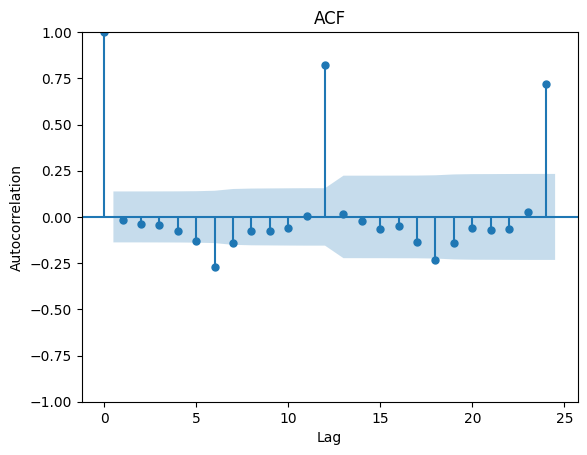

In [ ]:
# Refinement of the Model
residual= fit_model.resid
plot_acf(residuals)
plt.title('ACF')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

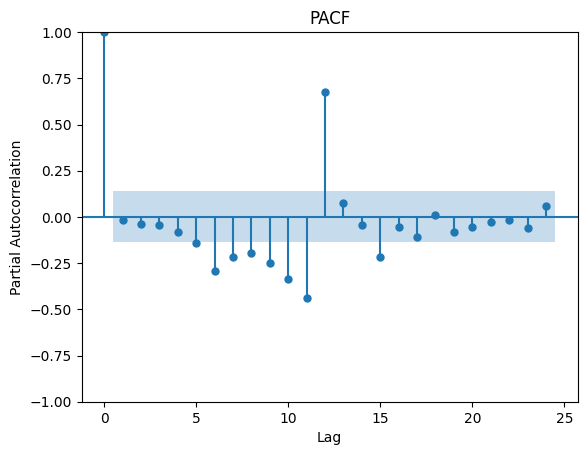

In [ ]:
plot_pacf(residuals)
plt.title('PACF')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [ ]:
order=(10,1,1)
print(f"ARIMA{order} - AIC: {fit_model.aic}")

ARIMA(10, 1, 1) - AIC: -172.68366275662925


In [ ]:
st = acorr_ljungbox(residuals, lags=[25],return_df=True)
print('\nLjung-Box Test Statistic:', st.lb_stat)
print('p-value:', st.lb_pvalue)


Ljung-Box Test Statistic: 25    320.428448
Name: lb_stat, dtype: float64
p-value: 25    4.675318e-53
Name: lb_pvalue, dtype: float64


In [ ]:
adf_kpss_test(residuals,1)

ADF Statistic: -4.503926397397996
p-value: 0.0001934524280632529
Critical Values:
	 1% : -3.465811691080702
	 5% : -2.877123351472649
	 10% : -2.5750770662586864

KPSS Statistic: 0.010587818822692666
p-value: 0.1
Critical Values:
	 10% : 0.347
	 5% : 0.463
	 2.5% : 0.574
	 1% : 0.739


<ipython-input-96-753d22cd55ea>:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss = kpss(diff_data)


In [ ]:
model_results['ARIMA(10, 1, 1)'] = {
    'AIC': -172.68366275662925,
    'Ljung-Box Test Statistic': 320.428448,
    'Ljung-Box p-value': 4.675318e-53,
    'ADF Statistic': -4.503926397397996,
    'ADF p-value': 0.0001934524280632529,
    'KPSS Statistic': 0.010587818822692666,
    'KPSS p-value': 0.1
}

From the above, we observe that it is not a stationary plot for p=10.Hence we continue refining the model by increasing the value of p.

In [ ]:
# Fit ARIMA model
model = ARIMA(diff_data, order=(13, 1, 1))
fit_model = model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

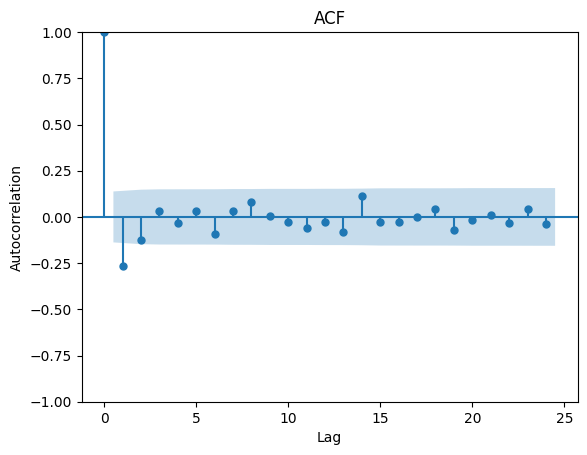

In [ ]:
# Refinement of the Model
residuals = fit_model.resid
plot_acf(residuals)
plt.title('ACF')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

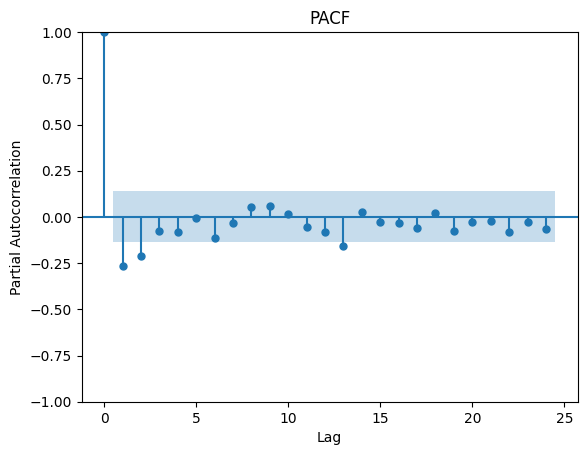

In [ ]:
plot_pacf(residuals)
plt.title('PACF')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

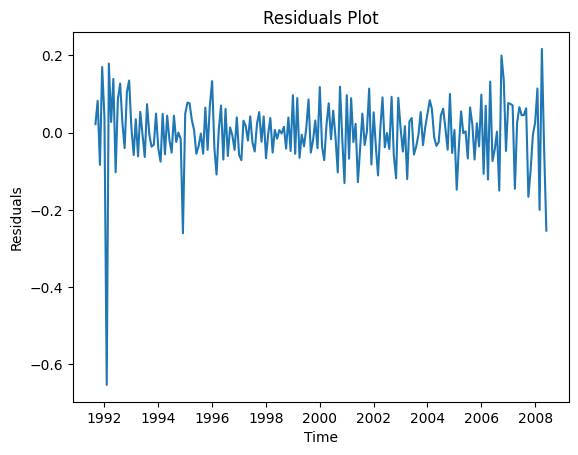

In [ ]:
plt.plot(residuals)
plt.title('Residuals Plot')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

Observing the above plots, we observe that the residuals are stationary.Hence, it is a good model when p=13

In [ ]:
order=(13,1,1)
print(f"ARIMA{order} - AIC: {fit_model.aic}")

ARIMA(13, 1, 1) - AIC: -425.83866495864225


In [ ]:
st = acorr_ljungbox(residuals, lags=[25],return_df=True)
print('\nLjung-Box Test Statistic:', st.lb_stat)
print('p-value:', st.lb_pvalue)


Ljung-Box Test Statistic: 25    31.679358
Name: lb_stat, dtype: float64
p-value: 25    0.1675
Name: lb_pvalue, dtype: float64


In [ ]:
adf_kpss_test(residuals,1)

ADF Statistic: -5.286614143713669
p-value: 5.836293152589946e-06
Critical Values:
	 1% : -3.4654311561944873
	 5% : -2.8769570530458792
	 10% : -2.574988319755886

KPSS Statistic: 0.04058095391279006
p-value: 0.1
Critical Values:
	 10% : 0.347
	 5% : 0.463
	 2.5% : 0.574
	 1% : 0.739


<ipython-input-96-753d22cd55ea>:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss = kpss(diff_data)


In [ ]:
model_results['ARIMA(13, 1, 1)'] = {
    'AIC': -425.83866495864225,
    'Ljung-Box Test Statistic': 31.679358,
    'Ljung-Box p-value': 0.1675,
    'ADF Statistic': -5.286614143713669,
    'ADF p-value': 5.836293152589946e-06,
    'KPSS Statistic':0.04058095391279006,
    'KPSS p-value': 0.1
}

Compare the results of all four models

In [ ]:
# Create a DataFrame from the dictionary
results_df = pd.DataFrame(model_results).T

# Display the DataFrame
print(results_df)

                        AIC  Ljung-Box Test Statistic  Ljung-Box p-value  \
ARIMA(2, 1, 1)  -127.521756                322.642336       1.671986e-53   
ARIMA(5, 1, 1)  -136.678900                320.428448       4.675318e-53   
ARIMA(10, 1, 1) -172.683663                320.428448       4.675318e-53   
ARIMA(13, 1, 1) -425.838665                 31.679358       1.675000e-01   

                 ADF Statistic  ADF p-value  KPSS Statistic  KPSS p-value  
ARIMA(2, 1, 1)       -3.819150     0.002717        0.039976           0.1  
ARIMA(5, 1, 1)       -4.503926     0.000193        0.010588           0.1  
ARIMA(10, 1, 1)      -4.503926     0.000193        0.010588           0.1  
ARIMA(13, 1, 1)      -5.286614     0.000006        0.040581           0.1  


AIC (Akaike Information Criterion):

For a given set of data, AIC measures the relative quality of statistical models. Models with lower AIC values are more likely to be well-fit.

AIC of ARIMA(13, 1, 1) is the lowest among the four models (-425.838665), indicating that it is the best-fitting model.

Ljung-Box Test Statistic and p-value:

To determine whether the residuals of the model exhibit significant autocorrelation, the Ljung-Box test is used.

The Ljung-Box test statistic for ARIMA(2, 1, 1), ARIMA(5, 1, 1), and ARIMA(10, 1, 1) is relatively high, indicating the presence of autocorrelation.

These models produce very low p-values, indicating strong evidence against the null hypothesis of no autocorrelation. As a result, the residuals appear to be autocorrelated.

Contrary to ARIMA(13, 1, 1), the Ljung-Box test statistic is lower, and the p-value is higher (0.1675). In contrast to other models, this indicates less evidence against the null hypothesis.

ADF (Augmented Dickey-Fuller) Test statistic and p-value:

To determine if a unit root is present in the residuals, which would indicate non-stationarity, the ADF test is used.

The ADF statistic is negative for all models, and the associated p-values are less than 0.05 (except for ARIMA(2, 1, 1)). Accordingly, the null hypothesis of non-stationarity is rejected for these models, indicating residual stationarity.

KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test statistic and p-value:

To determine whether residuals are trend-stationary or stationary around a deterministic trend, the KPSS test is used.

The KPSS statistic for all models is relatively low, and the associated p-values are greater than 0.05. These results suggest acceptance of the null hypothesis of stationarity, which indicates that residuals are stationary around a mean.



ARIMA(13, 1, 1) appears to be the most suitable model among the four, as it has the lowest AIC, relatively low Ljung-Box test statistic, and less evidence against the null hypothesis of no autocorrelation.

2008-07-01  22.92521592977835
2008-08-01  24.05642344840024
2008-09-01  23.645820215150103
2008-10-01  24.517054672880572
2008-11-01  26.181171858798425
2008-12-01  27.392407675240115
2009-01-01  30.77369446688276
2009-02-01  22.867064079224182
2009-03-01  19.71271631466481
2009-04-01  24.881853521758895
2009-05-01  24.332807088590044
2009-06-01  21.32004722654315
2009-07-01  25.202398297556346
2009-08-01  26.245442842574086
2009-09-01  25.77262467106574
2009-10-01  27.192139177368624
2009-11-01  28.43145620337203
2009-12-01  30.165944358908266
2010-01-01  33.11499904297481
2010-02-01  24.863947374981382
2010-03-01  21.869108034407763
2010-04-01  27.363875621998332
2010-05-01  26.428624407869574
2010-06-01  23.803006459286987
2010-07-01  28.117562393369692
2010-08-01  28.97199114237979
2010-09-01  28.491052664264075
2010-10-01  30.35589160252082
2010-11-01  31.20323049777811
2010-12-01  33.39381505043746
2011-01-01  35.93294296554224
2011-02-01  27.1889342579255
2011-03-01  24.40306516

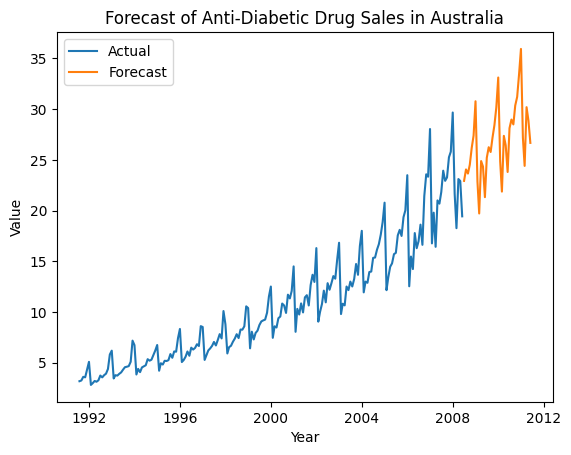

In [ ]:
# Forecasting

forecast = fit_model.forecast(steps=36)

# Convert forecast to original scale
getdates = pd.date_range(start=drug_data.index[-1], periods=37, freq='MS')[1:]

#inverse the differencing
forecast_log_values = np.cumsum(forecast) + np.log(drug_data['Value'].iloc[-1])

# Reverse the logarithmic transformation to obtain the forecasted values in the original scale
forecast_original_scale = np.exp(forecast_log_values)

# Print forecast values with corresponding dates
for date, value in zip(getdates, forecast_original_scale):
    print(f"{date.strftime('%Y-%m-%d')}  {value}")
# Plot forecast

plt.plot(drug_data['Value'], label='Actual')
plt.plot(getdates, forecast_original_scale, label='Forecast')
plt.title('Forecast of Anti-Diabetic Drug Sales in Australia')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()